# Описание данных

---


[events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами


---


* step_id - id стэпа
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие, возможные значения: 
  * discovered - пользователь перешел на стэп
  * viewed - просмотр шага,
  * started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
  * passed - удачное решение практического шага


---


[submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям


---


* step_id - id стэпа
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения
* user_id - анонимизированный id юзера

---

# Imports and settings

---

In [7]:
import seaborn as sns
from functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
%matplotlib inline
sns.set(font_scale=1.5)
sns.set(rc={"figure.figsize": (20, 10)})

---

# Подготовка данных для обучения

---
По условию, мы должны предсказать используя данные за первые два дня.

In [9]:
learning_time_treshold = 2 * 24 * 60 * 60 # 2 days in seconds

In [10]:
train_events_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip")

In [11]:
train_submission_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip")

In [12]:
X, y = get_x_y_train(train_events_data, train_submission_data, learning_time_treshold)

---

# Подготовка данных для предсказания

---

In [13]:
pred_events_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/events_data_test.csv")

In [14]:
pred_submission_data = pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")

In [15]:
X_pred = get_x_pred(pred_events_data, pred_submission_data)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

---

# Random Forest

---

In [17]:
scaler = StandardScaler()

In [18]:
pipe_rfc, train_score, test_score = random_forest_classifier(X_train, X_test, y_train, y_test, scaler)

In [19]:
res_df = pd.DataFrame({"Classifier": ["Random Forest"], "train_score": [train_score], "test_score": [test_score]})

## Random Forest Feature Importance

In [20]:
feature_imp = pd.Series(pipe_rfc[1].best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
fi_df = pd.DataFrame(feature_imp, columns=["importance"]).reset_index()
fi_df = fi_df.rename(columns={"index": "feature"})

<AxesSubplot:>

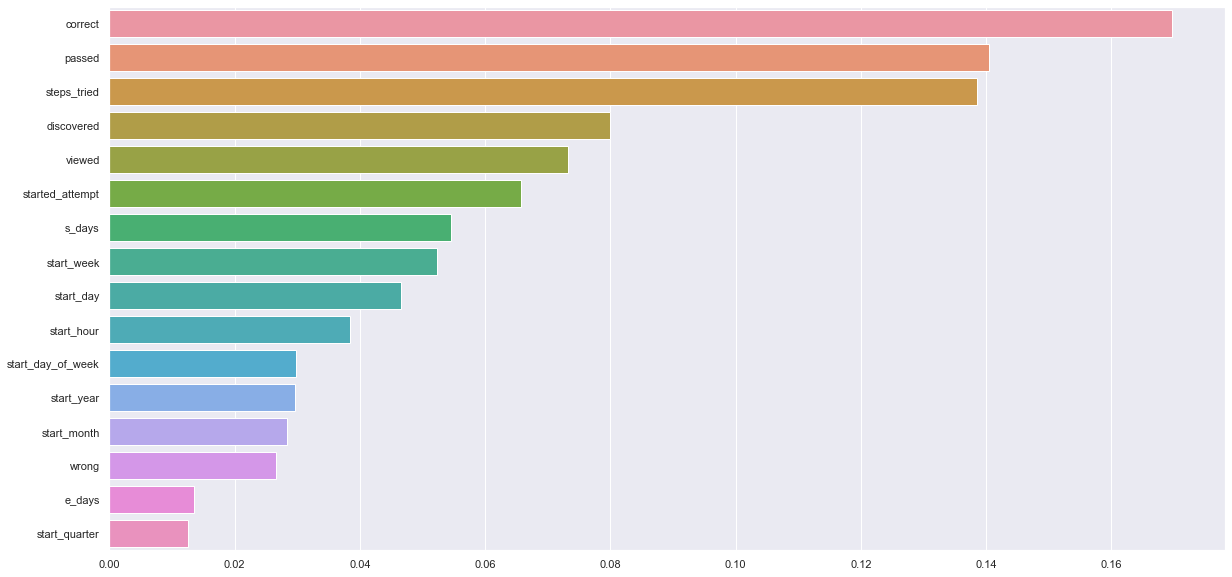

In [21]:
sns.barplot(x=feature_imp, y=feature_imp.index)

---

# Logistic Regression

---

In [22]:
pipe_lrc, train_score, test_score = linear_regression_classifier(X_train, X_test, y_train, y_test, scaler)

c:\users\ilya\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.83281788        nan 0.83285482 0.8300498  0.83282178        nan
 0.83522899 0.83285572        nan 0.83296131]
  warnings.warn(


In [23]:
res_df = res_df.append({"Classifier": "Logistic Regression",
                        "train_score": train_score, "test_score": test_score}, ignore_index=True)

---

# Naive Bayes

---

In [24]:
pipe_nbc, train_score, test_score = naive_bayes_classifier(X_train, X_test, y_train, y_test, scaler)

In [25]:
res_df = res_df.append({"Classifier": "Naive Bayes",
                        "train_score": train_score, "test_score": test_score}, ignore_index=True)

---

# Decision Tree

---

In [26]:
pipe_dtc, train_score, test_score = decision_tree_classifier(X_train, X_test, y_train, y_test, scaler)

In [27]:
res_df = res_df.append({"Classifier": "Decision Tree",
                        "train_score": train_score, "test_score": test_score}, ignore_index=True)

---

# Gradient Boosting

---

In [28]:
pipe_gbc, train_score, test_score = gradient_boosting_classifier(X_train, X_test, y_train, y_test, scaler)

In [29]:
res_df = res_df.append({"Classifier": "Gradient Boosting",
                        "train_score": train_score, "test_score": test_score}, ignore_index=True)

---

# Neural Network

---

In [30]:
pipe_nnc, train_score, test_score = neural_network_classifier(X_train, X_test, y_train, y_test, scaler)

In [31]:
res_df = res_df.append({"Classifier": "Neural Network",
                        "train_score": train_score, "test_score": test_score}, ignore_index=True)

---

# Predictions

---

In [32]:
res_df.sort_values("test_score", ascending=False)

,Classifier,train_score,test_score
4,Gradient Boosting,0.869827,0.864423
0,Random Forest,0.905171,0.862026
5,Neural Network,0.857932,0.852631
1,Logistic Regression,0.837315,0.848201
3,Decision Tree,0.856938,0.845104
2,Naive Bayes,0.818510,0.826007


In [33]:
pipes = [pipe_gbc, pipe_rfc, pipe_lrc, pipe_nnc, pipe_dtc, pipe_nbc]
labels = ["pipe_gbc", "pipe_rfc", "pipe_lrc", "pipe_nnc", "pipe_dtc", "pipe_nbc"]

In [34]:
for i in range(len(pipes)):
  y_pred = pipes[i].predict_proba(X_pred)
  save_df = pd.DataFrame({"user_id": X_pred.index, "is_gone": y_pred[:, 1]})
  save_df.to_csv("results/" + labels[i] + ".csv", index=False)

Stepic testing
* Gradient Boosting - 0.887
* Linear Regression - 0.877
* Naive Bayes - 0.869
* Random Forest - 0.866
* Decision Tree - 0.819
* Neural Network - 0.776

Лучший достигнутый результат (0.887) получен при использовании Gradient Boosting (Top 20).